Electron: WaveFunction Initialized.
Electron: WaveFunction Normalized.
Proton: WaveFunction Initialized.
Proton: WaveFunction Normalized.
ELectron Expectation Values: 25.000000000000004,25.000000000000004
Proton Expectation Values: 25.0,24.999999999999996


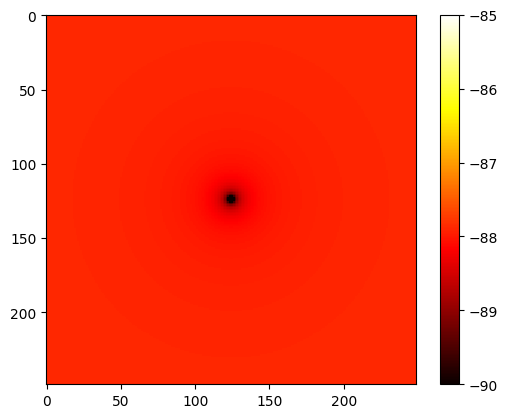

Electron: Starting Matrices.
Proton: Starting Matrices.
Electron Expectation Values: 25.000000000000004,25.000000000000004
Proton Expectation Values: 25.0,24.999999999999996


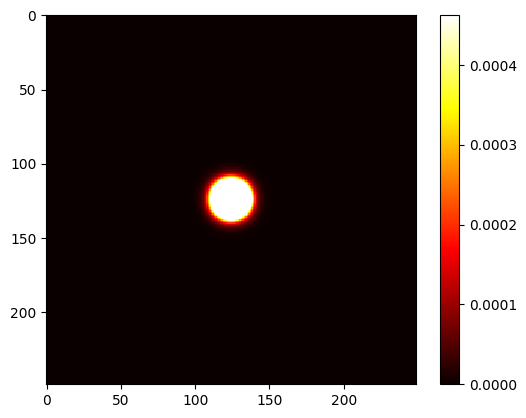

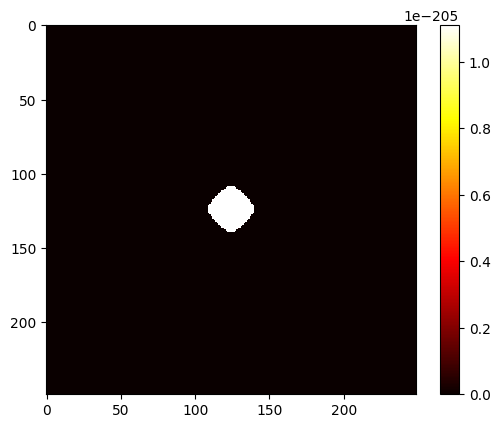

Time: 0.0
Electron Expectation Values: 24.999999999985654,24.999999999985654
Proton Expectation Values: 24.999999999999993,24.99999999999999
Time: 0.010000000000000002
Electron Expectation Values: 24.99999999994261,24.999999999942606
Proton Expectation Values: 24.99999999999997,24.999999999999968
Time: 0.020000000000000004
Electron Expectation Values: 24.999999999870866,24.999999999870873
Proton Expectation Values: 24.999999999999957,24.999999999999954
Time: 0.030000000000000006
Electron Expectation Values: 24.999999999770456,24.999999999770452
Proton Expectation Values: 24.999999999999964,24.999999999999964
Time: 0.04000000000000001
Electron Expectation Values: 24.99999999964139,24.99999999964139
Proton Expectation Values: 24.999999999999964,24.999999999999964
Time: 0.05000000000000001
Electron Expectation Values: 24.99999999948371,24.999999999483713
Proton Expectation Values: 24.999999999999982,24.999999999999982
Time: 0.06000000000000001
Electron Expectation Values: 24.9999999992974

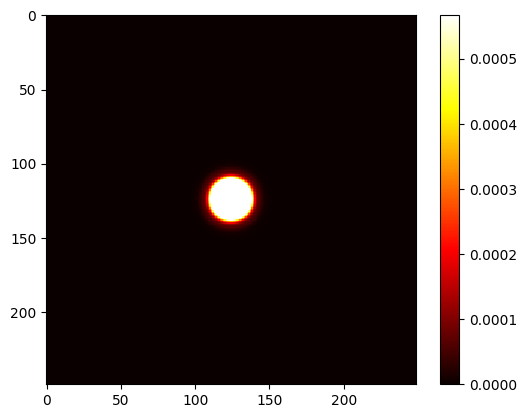

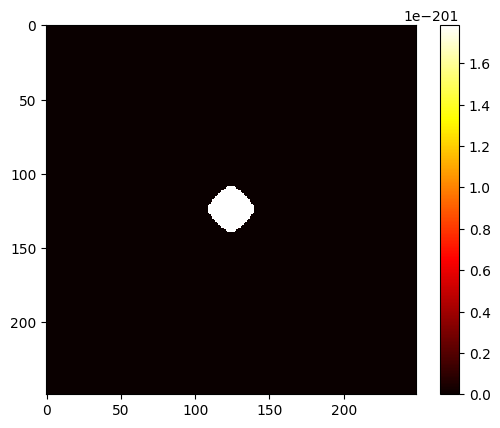

Time: 1.0000000000000002
Electron Expectation Values: 24.999999877250605,24.99999987725061
Proton Expectation Values: 24.999999999999822,24.999999999999822
Time: 1.0100000000000002
Electron Expectation Values: 24.999999875226106,24.999999875226113
Proton Expectation Values: 24.999999999999815,24.999999999999815
Time: 1.0200000000000002
Electron Expectation Values: 24.999999873196582,24.99999987319659
Proton Expectation Values: 24.999999999999822,24.999999999999822
Time: 1.0300000000000002
Electron Expectation Values: 24.99999987116239,24.99999987116239
Proton Expectation Values: 24.999999999999826,24.999999999999822
Time: 1.0400000000000003
Electron Expectation Values: 24.999999869123897,24.9999998691239
Proton Expectation Values: 24.99999999999981,24.999999999999808
Time: 1.0500000000000003
Electron Expectation Values: 24.999999867081467,24.999999867081467
Proton Expectation Values: 24.99999999999981,24.999999999999808
Time: 1.0600000000000003
Electron Expectation Values: 24.999999865

In [ ]:
import numpy as np
import scipy.constants as sc
import scipy.sparse as sparse
import matplotlib.pyplot as plt

#Constants
a = 5.29177210903e-11
G = sc.G * ((4*sc.pi*sc.epsilon_0)**4)*(sc.hbar**6)/((a**3)*(sc.e**8)*(sc.electron_mass))
mbh = (3.562926140333641*10**16)/sc.electron_mass
mp = sc.proton_mass/sc.electron_mass
c = sc.c*((sc.hbar**3)*(sc.pi*sc.epsilon_0*4)**2)/(a*sc.electron_mass*sc.e**4)

#Parameters
gridLength = 50
dr = 0.2
N = int(gridLength/dr)+1
dt = dr**2/4
x0 = 25
y0 = 25
xbh = 25-(100/np.sqrt(2))
ybh = 25-(100/np.sqrt(2))
time = 0
timeEnd = 10+dt

#L to dimensional conversions
def calcL(I, J):
    return int((I - 1) + (J - 1)*(N - 2))

def calcI(L): 
    return int(((L % (N-2)) + 1))

def calcJ(L):
    return int(((L - L % (N-2)) / (N-2))+1)

#Calc probability distribution
def modulusSquared(number):
    return np.abs(number)**2

#Gravitational gradient function
def gravitationalPotential(L,mass):
    return(-1 * G * mbh * mass/np.sqrt(((calcI(L)*dr)-xbh)**2+((calcJ(L)*dr)-ybh)**2))

class WaveFunction:
    
    def __init__(self, initial, name,mass,sigma):
        self.name = name
        #Discretize initial wave function
        self.psi = np.array([initial(L) for L in range((N-2)**2)])
        print(f'{self.name}: WaveFunction Initialized.')
        #Normalize initial wave function
        self.normalize()
        #Add probability distribution to list for storage
        self.psis = [modulusSquared(self.psi).reshape(N-2,N-2)]
        print(f"{self.name}: WaveFunction Normalized.")
        self.mass = mass
        self.constant = 1j*dt/(mass*4*dr**2)
        #Discretize gravitatioanl potential function
        self.gravitationalPotential = np.array([gravitationalPotential(L,self.mass) for L in range((N-2)**2)])
        self.expXs = []
        self.expYs = []
        self.sigma = sigma
    
    def normalize(self):
        normConst = np.sqrt(1/np.sum(modulusSquared(self.psi) * dr))
        self.psi *= normConst
    
    #Discretize electrostatic potential and sum with already-discretized gravitational potential.
    def calcPotential(self, attractor):
        electricPotential = np.array([electrostaticPotential(L,attractor) for L in range((N-2)**2)])
        self.V = np.array([(self.gravitationalPotential[L] + electricPotential[L]) for L in range((N-2)**2)],dtype=complex)
    
    def calcExpVals(self):
        #Assign X and Y  values to each value of L
        I = np.vectorize(calcI)
        J = np.vectorize(calcJ)
        X = I(range((N-2)**2)) * dr
        Y = J(range((N-2)**2)) * dr
        probDistribution = modulusSquared(self.psi)
        #Calculate expectation values and append to list
        self.expX = np.sum(probDistribution*X*dr)
        self.expY = np.sum(probDistribution*Y*dr)
        self.expXs.append(self.expX)
        self.expYs.append(self.expY)
    

    #Construct matrices A and B
    def createCNMatrices(self):
        print(f"{self.name}: Starting Matrices.")
        #Create A1, A2, B1, B2. Create A1 and B1 without their diagonals. Initialize A and B with the intention of vertical stacking.
        self.A = sparse.coo_matrix((0,(N-2)**2))
        A1 = sparse.diags([-self.constant, -self.constant], [-1, 1], shape=(N-2, N-2), format="coo")
        A2 = sparse.diags([-self.constant], [0], shape=(N-2, N-2), format="coo")
        self.B = sparse.coo_matrix((0,(N-2)**2))
        B1 = sparse.diags([self.constant, self.constant], [-1, 1], shape=(N-2, N-2), format="coo")
        B2 = sparse.diags([self.constant], [0], shape=(N-2, N-2), format="coo")
        #Construct tridiagonal block matrices A and B row by row using N-2XN-2 components
        for j in range(1,N-1):
            ALeftRow = sparse.coo_matrix((N-2,0))
            BLeftRow = sparse.coo_matrix((N-2,0))
            leftRow = sparse.coo_matrix((N-2,0))
            if j > 1:
                for i in range(j-2):
                    leftRow = sparse.hstack([leftRow,sparse.coo_matrix((N-2,N-2))])
                ALeftRow = sparse.hstack([leftRow,A2])
                BLeftRow = sparse.hstack([leftRow,B2])
            ARightRow = sparse.coo_matrix((N-2,0))
            BRightRow = sparse.coo_matrix((N-2,0))
            rightRow = sparse.coo_matrix((N-2,0))
            if j < N-2:
                for i in range((N-2-j)-1):
                    rightRow = sparse.hstack([rightRow,sparse.coo_matrix((N-2,N-2))])
                ARightRow = sparse.hstack([A2,rightRow])
                BRightRow = sparse.hstack([B2,rightRow])
            ATotalRow = sparse.hstack([ALeftRow,A1,ARightRow])
            BTotalRow = sparse.hstack([BLeftRow,B1,BRightRow])
            self.A = sparse.vstack([self.A,ATotalRow])
            self.B = sparse.vstack([self.B,BTotalRow])
        #Convert to csr for easier calculations
        self.A = self.A.tocsr()
        self.B = self.B.tocsr()
        #Set the diagonal of each matrix. This is done separately because it must be redone each timestep with a new potential.
        self.setDiagonal(self.A)
        self.setDiagonal(self.B)        
    
    def setDiagonal(self,array):
        if array is self.A:
            diag = 1 + 4*self.constant + (1j*dt*self.V)/2
        elif array is self.B:
            diag = 1 - 4*self.constant - (1j*dt*self.V)/2
        array.setdiag(diag)


#initial electron wave function
def electronPsi(L):
    return ((1 / np.sqrt(np.pi))*np.exp(-1*np.sqrt((calcI(L)*dr-x0)**2+(calcJ(L)*dr-y0)**2)))

#Generic electrostatic function
def electrostaticPotential(L, attractor):
    xDist = (calcI(L) * dr) - attractor.expX
    yDist = (calcJ(L) * dr) - attractor.expY
    rSquared = xDist**2 + yDist**2
    #Gaussian smearing to prevent singularity
    return -1/np.sqrt(rSquared+attractor.sigma**2)


prsigma = dr/2

#initial proton wave function
def protonPsi(L):
    return (1/np.sqrt(2*np.pi*(prsigma)**2))*np.exp(-1 / (2 * (prsigma)**2) * ((calcI(L)*dr - x0)**2 + (calcJ(L)*dr - y0)**2))

#Initialize an electron and proton and display their relevant information. Create Crank-Nicolson matrices for both.
el = WaveFunction(electronPsi, "Electron",1,1)
pr = WaveFunction(protonPsi,"Proton", mp,prsigma)
el.calcExpVals()
print(f'ELectron Expectation Values: {el.expX},{el.expY}')
pr.calcExpVals()
print(f'Proton Expectation Values: {pr.expX},{pr.expY}')
el.calcPotential(pr)
pr.calcPotential(el)
plt.imshow(el.V.reshape(N-2,N-2).real, cmap='hot', interpolation='nearest', vmin=-90, vmax=-85)
plt.colorbar()
plt.show()
el.createCNMatrices()
pr.createCNMatrices()

def crankNicholsonStep(obj):
    #Turn psi into a column matrix and multiply by matrix B to get b
    b = obj.B @ obj.psi.reshape(-1,1)
    #Solve the system of linear equationa A*psi = b for a new psi
    obj.psi = sparse.linalg.spsolve(obj.A,b)
    #Append the new probability distribution for storage
    temp = modulusSquared(obj.psi).reshape(N-2,N-2)
    obj.psis.append(temp)
    if t % 100 == 0:
        vmin, vmax = np.percentile(temp, [1, 99])
        plt.imshow(temp, cmap='hot', interpolation='nearest', vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.show()   

def recalcPotentials(obj1,obj2):
    #Recalculate expectation values for use in potential calculation
    obj1.calcExpVals()
    print(f'{obj1.name} Expectation Values: {el.expX},{el.expY}') 
    obj2.calcExpVals()
    print(f'{obj2.name} Expectation Values: {pr.expX},{pr.expY}') 
    #Recalculate and reapply potential energy
    obj1.calcPotential(obj2)
    obj2.calcPotential(obj1)
    obj1.setDiagonal(obj1.A)
    obj1.setDiagonal(obj1.B)
    obj2.setDiagonal(obj2.A)
    obj2.setDiagonal(obj2.B)

for t in range(0, int((timeEnd/dt)+1)):
    #Time loop
    recalcPotentials(el,pr)
    crankNicholsonStep(el)
    crankNicholsonStep(pr)
    print("Time: " + str(float(t*dt)))


In [ ]:
vmin = 0.000005
vmax = 0.001
plt.imshow(pr.psis[0], cmap='hot', interpolation='nearest', vmin=vmin/10**-2, vmax=vmax)
plt.colorbar()
plt.show() 
for i in range(11):
    plt.imshow(el.psis[int(i/dt)], cmap='hot', interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show() 
print("Electron Displacement:") 
plt.plot(range(0,int(timeEnd/dt+2)),np.sqrt((el.expXs[0]-el.expXs)**2+(el.expYs[0]-el.expYs)**2))
plt.show()
for i in range(11):
    print(np.sqrt((el.expXs[0]-el.expXs[int(i/dt)])**2+(el.expYs[0]-el.expYs[int(i/dt)])**2))
print("Proton Displacement:") 
plt.plot(range(0,int(timeEnd/dt+2)),np.sqrt((pr.expXs[0]-pr.expXs)**2+(pr.expYs[0]-pr.expYs)**2))
plt.show()
for i in range(11):
    print(np.sqrt((pr.expXs[0]-pr.expXs[int(i/dt)])**2+(pr.expYs[0]-pr.expYs[int(i/dt)])**2))
print("Proton-Electron Distances:")
distances = np.array([np.sqrt((pr.expXs[L]-el.expXs[L])**2+(pr.expYs[L]-el.expYs[L])**2) for L in range(0,int(timeEnd/dt+2))])
plt.plot(range(0,int(timeEnd/dt+2)),distances)
plt.show()
for i in range(11):
        print(np.sqrt((pr.expXs[int(i/dt)]-el.expXs[int(i/dt)])**2+(pr.expYs[int(i/dt)]-el.expYs[int(i/dt)])**2))
